# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers, losses, activations, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Input, Dropout, Convolution1D, MaxPool1D, GlobalMaxPool1D, GlobalAveragePooling1D, concatenate, SimpleRNN, LSTM
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
from sklearn.metrics import f1_score, accuracy_score
from sklearn.decomposition import PCA

# Data Loading

In [ ]:
df_train = pd.read_csv("drive/MyDrive/MLHC/archive/mitbih_train.csv", header=None)
df_train = df_train.sample(frac=1)
df_test = pd.read_csv("drive/MyDrive/MLHC/archive/mitbih_test.csv", header=None)

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]


In [ ]:
print(Y_test.shape,X_test.shape,Y.shape,X.shape)

(21892,) (21892, 187, 1) (87554,) (87554, 187, 1)


# Data distribution

Text(0, 0.5, 'Test set')

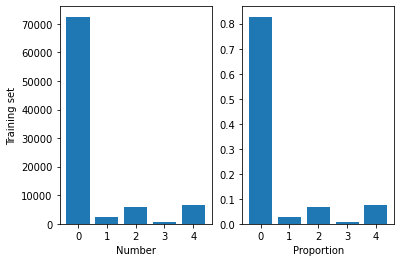

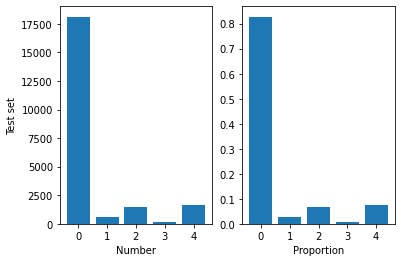

In [ ]:
class_names = [str(i) for i in range(5)]
labels, counts = np.unique(Y, return_counts=True)

fig, axs = plt.subplots(1, 2)
axs[0].bar(labels, counts, align='center')
axs[0].set_xticks(labels)
axs[0].set_xlabel('Number')
axs[1].bar(labels, counts/Y.shape[0], align='center')
axs[1].set_xticks(labels)
axs[1].set_xlabel('Proportion')
axs[0].set_ylabel("Training set")

labels, counts = np.unique(Y_test, return_counts=True)
fig, axs = plt.subplots(1, 2)
axs[0].bar(labels, counts, align='center')
axs[0].set_xticks(labels)
axs[0].set_xlabel('Number')
axs[1].bar(labels, counts/Y_test.shape[0], align='center')
axs[1].set_xticks(labels)
axs[1].set_xlabel('Proportion')
axs[0].set_ylabel("Test set")

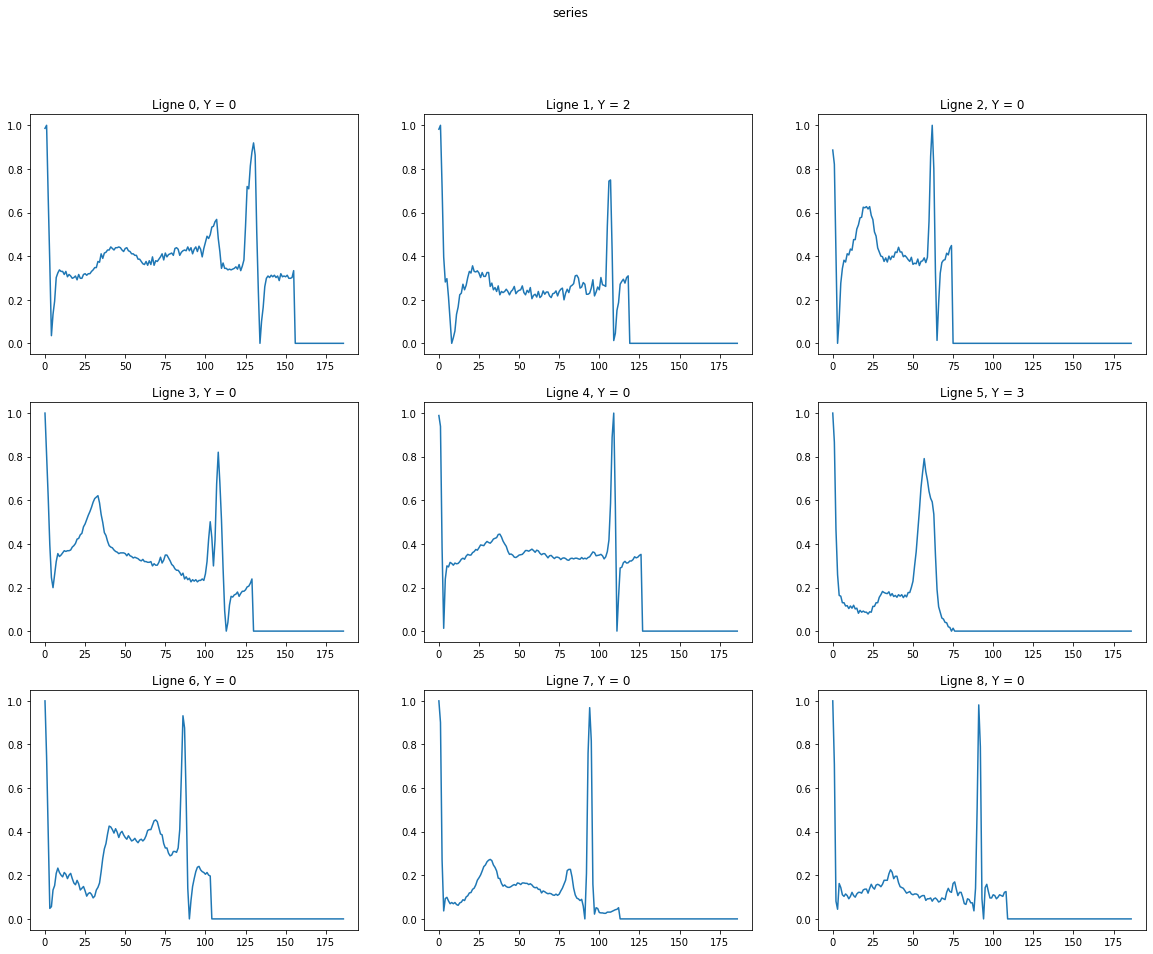

In [ ]:
plt.figure(figsize=(20,15))
plt.suptitle("series")
for j in range(9):
  plt.subplot(3,3,j+1)
  plt.plot(X[j])
  plt.title("Ligne " + str(j) + ", Y = " + str(Y[j])) 

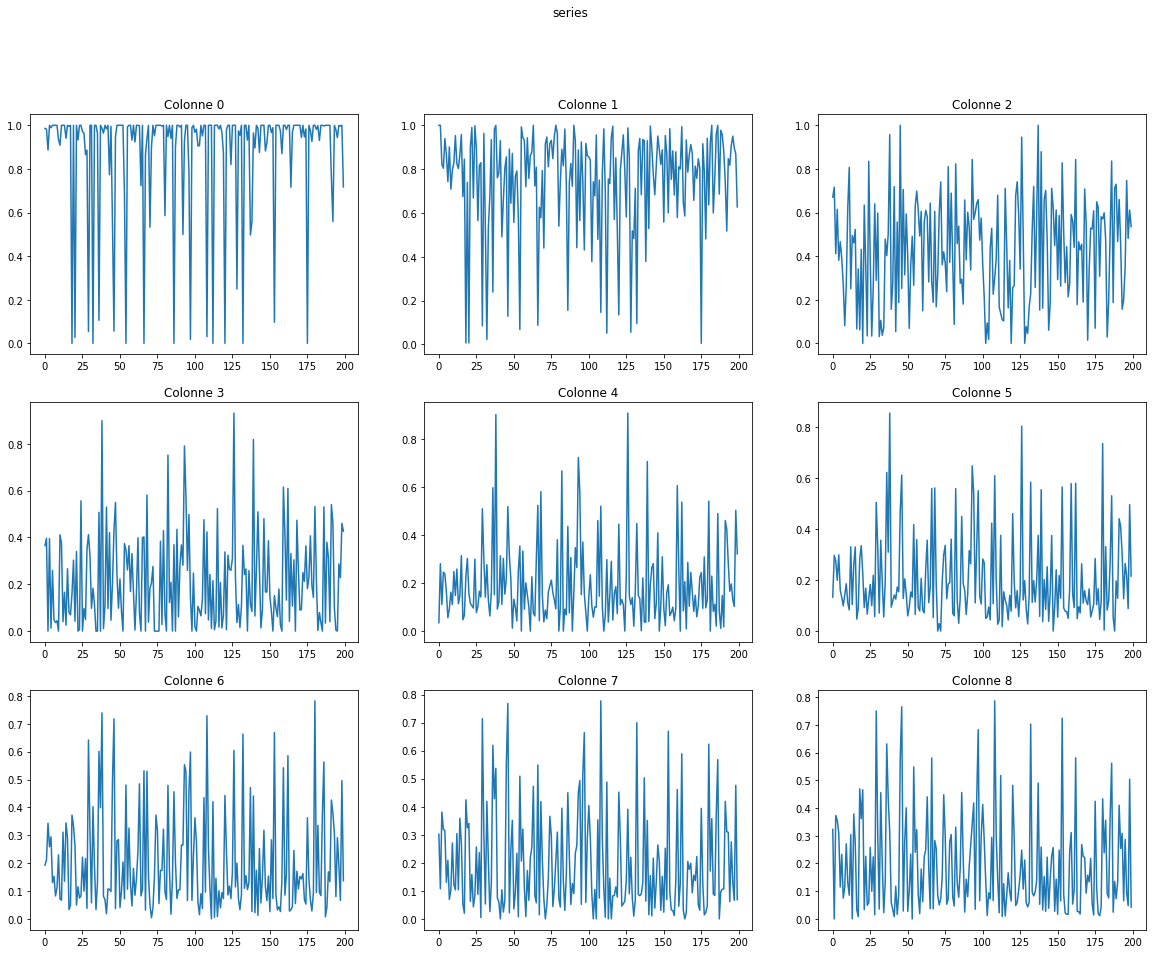

In [ ]:
plt.figure(figsize=(20,15))
plt.suptitle("series")
for j in range(9):
  plt.subplot(3,3,j+1)
  plt.plot(X[:200,j])
  plt.title("Colonne " + str(j)) 

# Data balancing : 10 000 samples for each

In [ ]:
X0 = X[Y==0]
X1 = X[Y==1]
X2 = X[Y==2]
X3 = X[Y==3]
X4 = X[Y==4]
XeachClass = [X0,X1,X2,X3,X4]
print(X0.shape,X1.shape,X2.shape,X3.shape,X4.shape)

def getRandomImageFromClass(classNumber):
  randomint = np.random.randint(XeachClass[classNumber].shape[0])
  return XeachClass[classNumber][randomint]

(72471, 187, 1) (2223, 187, 1) (5788, 187, 1) (641, 187, 1) (6431, 187, 1)


In [ ]:
N = 10000
X_balanced = []
Y_balanced = []
numberEachClass = np.zeros(5,dtype='int')
for i in range(X.shape[0]):
  if numberEachClass[Y[i]] < N:
    X_balanced.append(X[i])
    Y_balanced.append(Y[i])
    numberEachClass[Y[i]]+=1

N0 = N - numberEachClass[0]
N1 = N - numberEachClass[1]
N2 = N - numberEachClass[2]
N3 = N - numberEachClass[3]
N4 = N - numberEachClass[4]
    
NtoComplete = [N0,N1,N2,N3,N4]
print("Number of each class to add to balance ",NtoComplete)
for classIndex in range(5):
  Nclass = NtoComplete[classIndex]
  for i in range(Nclass):
    X_balanced.append(getRandomImageFromClass(classIndex))
    Y_balanced.append(classIndex)

print(len(X_balanced),X_balanced[0].shape)
  
X_balanced = np.reshape(X_balanced, (5*N,X.shape[1],X.shape[2]))
Y_balanced = np.reshape(Y_balanced,(5*N,))

newOrder = np.arange(Y_balanced.shape[0])
np.random.shuffle(newOrder)

X_balanced = X_balanced[newOrder]
Y_balanced = Y_balanced[newOrder]

print(X_balanced.shape,Y_balanced)

Number of each class to add to balance  [0, 7777, 4212, 9359, 3569]
50000 (187, 1)
(50000, 187, 1) [3 0 3 ... 2 2 2]


Text(0, 0.5, 'Balanced training set')

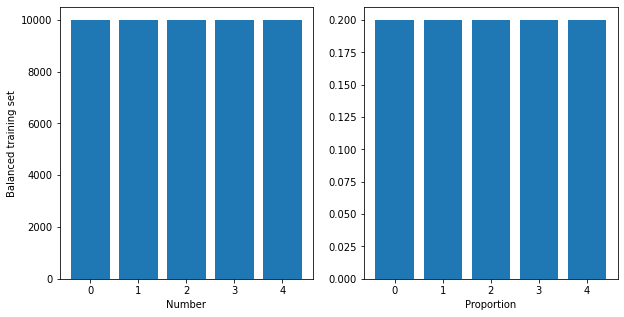

In [ ]:
labels, counts = np.unique(Y_balanced, return_counts=True)
fig, axs = plt.subplots(1, 2)
fig.set_size_inches(10,5)
axs[0].bar(labels, counts, align='center')
axs[0].set_xticks(labels)
axs[0].set_xlabel('Number')
axs[1].bar(labels, counts/Y_balanced.shape[0], align='center')
axs[1].set_xticks(labels)
axs[1].set_xlabel('Proportion')
axs[0].set_ylabel("Balanced training set")

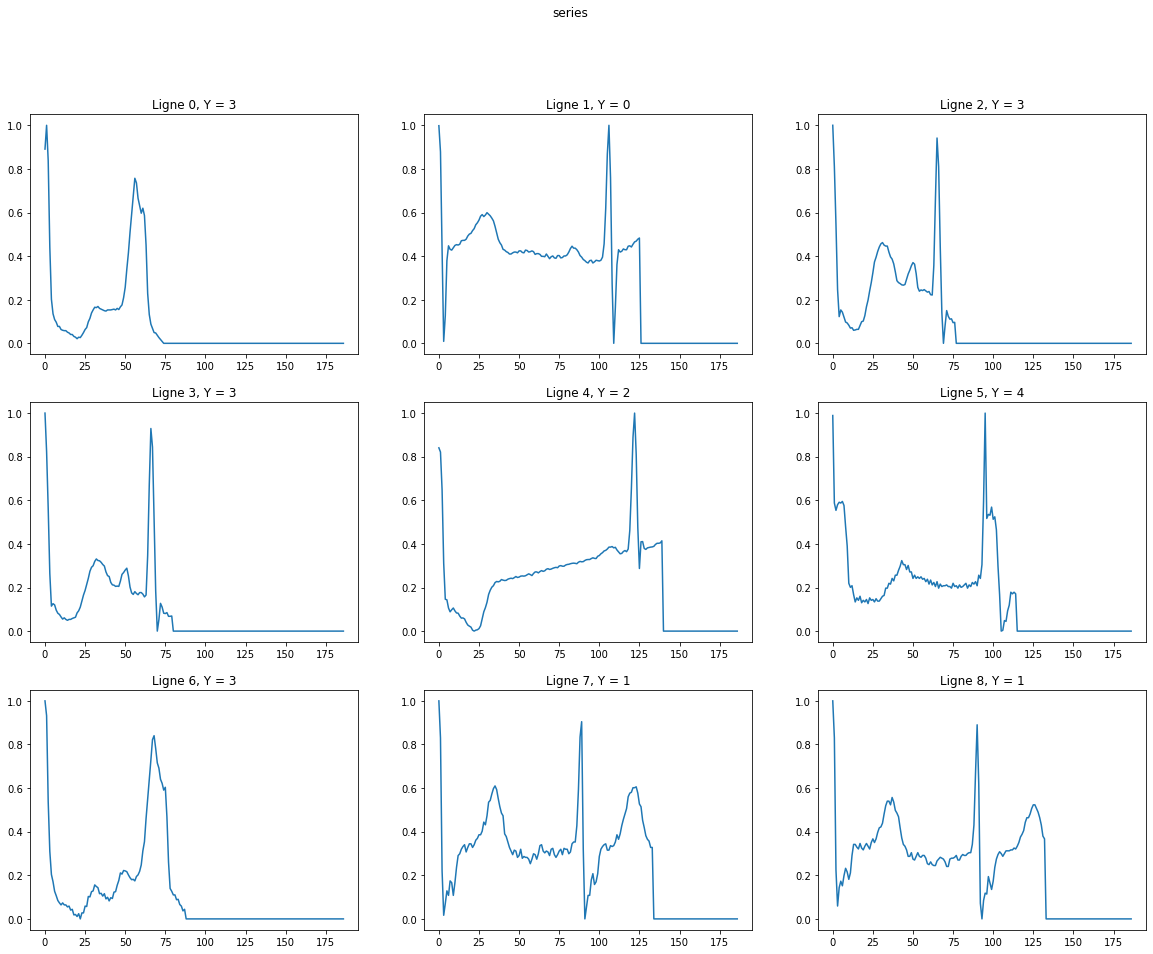

In [ ]:
plt.figure(figsize=(20,15))
plt.suptitle("series")
for j in range(9):
  plt.subplot(3,3,j+1)
  plt.plot(X_balanced[j])
  plt.title("Ligne " + str(j) + ", Y = " + str(Y_balanced[j])) 

# Data scaling

In [ ]:
# print(np.mean(X),np.var(X))
# scaler = StandardScaler()
# scaler.fit(X)
# X_c = scaler.transform(X)
# print(np.mean(X_c),np.var(X_c))
# print(np.mean(X_test),np.var(X_test))
# X_test_c = scaler.transform(X_test)
# print(np.mean(X_test_c),np.var(X_test_c))

# PCA

In [ ]:
# pca = PCA() 
# pca.fit(X_c)
# X_PCA = pca.transform(X_c)
# print("Nombre de features :", X_PCA.shape[1])
# var_explained = pca.explained_variance_ratio_*100 
# #print("Variance pca des nouvelles features :\n",var_explained)
# number_features = np.argmax(np.cumsum(var_explained)>99)+1 
# print("Nombre de features pour avoir 99 pourcents de la variance :",number_features)
# X_PCA_99 = X_PCA[:,:number_features]
# X_test_PCA = pca.transform(X_test_c)
# X_test_PCA_99 = X_test_PCA[:,:number_features]
# print(X_PCA_99.shape,X_test_PCA_99.shape)

# Models

## LSTM

In [ ]:
def get_lstm_dense():
  nclass = 5
  inp = Input(shape=(187, 1))
  rnn = LSTM(128,return_sequences=True)(inp)
  rnn = LSTM(64,return_sequences=True)(rnn)
  drop = Dropout(rate=0.2)(rnn)
  dense = Dense(64, activation=activations.relu)(drop)
  dense = Dense(32, activation=activations.relu)(dense)
  dense2 = Dense(nclass, activation=activations.softmax)(dense)
  model = models.Model(inputs=inp, outputs=dense2)
  opt = optimizers.Adam(0.001)
  model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
  model.summary()
  return model

In [ ]:
def get_lstm_dense_2():
  nclass = 5
  inp = Input(shape=(187, 1))
  rnn = LSTM(256)(inp)
  #rnn = LSTM(64,return_sequences=True)(rnn)
  drop = Dropout(rate=0.2)(rnn)
  dense = Dense(64, activation=activations.relu)(drop)
  dense = Dense(64, activation=activations.relu)(dense)
  dense2 = Dense(nclass, activation=activations.softmax)(dense)
  model = models.Model(inputs=inp, outputs=dense2)
  opt = optimizers.Adam(0.001)
  model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
  model.summary()
  return model

In [ ]:
def get_lstm_dense_3():
  nclass = 5
  inp = Input(shape=(187, 1))
  rnn = LSTM(128,return_sequences=True)(inp)
  rnn = Dropout(rate=0.2)(rnn)
  rnn = LSTM(64)(rnn)
  dense = Dense(32, activation=activations.relu)(rnn)
  dense2 = Dense(nclass, activation=activations.softmax)(dense)
  model = models.Model(inputs=inp, outputs=dense2)
  opt = optimizers.Adam(0.001)
  model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
  model.summary()
  return model

In [ ]:
def get_only_lstm():
  nclass = 5
  inp = Input(shape=(187, 1))
  rnn = LSTM(128)(inp)
  #rnn = LSTM(64,return_sequences=True)(rnn)
  #rnn = Dropout(rate=0.2)(rnn)
  #rnn = LSTM(32,return_sequences=True)(rnn)
  #rnn = LSTM(64,activation=activations.relu)(rnn)
  #dense = Dense(64, activation=activations.relu)(drop)
  #dense = Dense(32, activation=activations.relu)(rnn)
  dense2 = Dense(nclass, activation=activations.softmax)(rnn)
  model = models.Model(inputs=inp, outputs=dense2)
  opt = optimizers.Adam(0.0001)
  model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
  model.summary()
  return model

## MLP

In [ ]:
def mlp():
  nclass = 5
  inp = Input(shape=(187))
  #rnn = LSTM(256)(inp)
  #rnn = LSTM(64,return_sequences=True)(rnn)
  #drop = Dropout(rate=0.2)(rnn)
  dense = Dense(128, activation=activations.relu)(inp)
  dense = Dense(256, activation=activations.relu)(dense)
  dense = Dense(256, activation=activations.relu)(dense)
  drop = Dropout(0.2)(dense)
  dense = Dense(128, activation=activations.relu)(drop)
  dense = Dense(64, activation=activations.relu)(dense)
  dense = Dense(64, activation=activations.relu)(dense)
  dense = Dense(32, activation=activations.relu)(dense)
  dense2 = Dense(nclass, activation=activations.softmax)(dense)
  model = models.Model(inputs=inp, outputs=dense2)
  opt = optimizers.Adam(0.01)
  model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
  model.summary()
  return model

## RNN

In [ ]:
def get_rnn_dense():
  nclass = 5
  inp = Input(shape=(187, 1))
  rnn = SimpleRNN(128,return_sequences=True)(inp)
  rnn = SimpleRNN(256,return_sequences=True)(rnn)
  rnn = SimpleRNN(128)(rnn)

  drop = Dropout(rate=0.1)(rnn)
  #dense = Dense(64, activation=activations.relu)(drop)
  dense = Dense(64, activation=activations.relu)(drop)
  dense = Dense(nclass, activation=activations.softmax)(dense)

  model = models.Model(inputs=inp, outputs=dense)
  opt = optimizers.Adam(0.01)
  model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
  model.summary()
  return model

## Conv1D

In [ ]:
def get_model():
    nclass = 5
    inp = Input(shape=(187, 1))
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(inp)
    img_1 = Convolution1D(16, kernel_size=5, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(32, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = MaxPool1D(pool_size=2)(img_1)
    img_1 = Dropout(rate=0.1)(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = Convolution1D(256, kernel_size=3, activation=activations.relu, padding="valid")(img_1)
    img_1 = GlobalMaxPool1D()(img_1)
    img_1 = Dropout(rate=0.2)(img_1)

    dense_1 = Dense(64, activation=activations.relu, name="dense_1")(img_1)
    dense_1 = Dense(64, activation=activations.relu, name="dense_2")(dense_1)
    dense_1 = Dense(nclass, activation=activations.softmax, name="dense_3_mitbih")(dense_1)

    model = models.Model(inputs=inp, outputs=dense_1)
    opt = optimizers.Adam(0.001)

    model.compile(optimizer=opt, loss=losses.sparse_categorical_crossentropy, metrics=['acc'])
    model.summary()
    return model

# Fit model

In [ ]:
model = get_rnn_dense()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 187, 1)]          0         
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 187, 128)          16640     
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 187, 256)          98560     
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 5)                 325 

In [ ]:
class_weights = {}
for i in range(5):
  class_weights[i] = (Y==0).sum()/(Y==i).sum()
print(class_weights)

{0: 1.0, 1: 32.60053981106613, 2: 12.520905321354526, 3: 113.05928237129486, 4: 11.269009485305551}


In [ ]:
print(X.shape,X[:,:,0].shape,Y.shape)

(87554, 187, 1) (87554, 187) (87554,)


In [ ]:
#file_path = "lstm_mitbih.h5"
#checkpoint = ModelCheckpoint(file_path, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
#early = EarlyStopping(monitor="val_acc", mode="max", patience=5, verbose=1)
#redonplat = ReduceLROnPlateau(monitor="val_acc", mode="max", patience=3, verbose=2)
#callbacks_list = [checkpoint, early, redonplat]  # early
#model.fit(X, Y, epochs=10, verbose=2, callbacks=callbacks_list, validation_split=0.1)
#model.fit(X, Y, epochs=10, verbose=2, validation_split=0.1,class_weight=class_weights)
history = model.fit(X, Y, epochs=10, verbose=2, validation_split=0.1)
#model.fit(X[:,:,0], Y, epochs=50, verbose=2, validation_split=0.1)

#model.load_weights(file_path)

Epoch 1/10
2463/2463 - 1787s - loss: 0.6709 - acc: 0.8268 - val_loss: 0.6587 - val_acc: 0.8318 - 1787s/epoch - 726ms/step
Epoch 2/10
2463/2463 - 1801s - loss: 0.6609 - acc: 0.8273 - val_loss: 0.6489 - val_acc: 0.8318 - 1801s/epoch - 731ms/step
Epoch 3/10
2463/2463 - 1810s - loss: 0.6588 - acc: 0.8273 - val_loss: 0.6473 - val_acc: 0.8318 - 1810s/epoch - 735ms/step
Epoch 4/10


In [ ]:
history2 = model.fit(X, Y, epochs=10, verbose=2, validation_split=0.1)

Epoch 1/10
2463/2463 - 205s - loss: 0.6413 - acc: 0.8296 - val_loss: 0.6463 - val_acc: 0.8318 - 205s/epoch - 83ms/step
Epoch 2/10
2463/2463 - 204s - loss: 0.5791 - acc: 0.8403 - val_loss: 0.3933 - val_acc: 0.8972 - 204s/epoch - 83ms/step
Epoch 3/10
2463/2463 - 204s - loss: 0.3703 - acc: 0.9010 - val_loss: 0.3263 - val_acc: 0.9195 - 204s/epoch - 83ms/step
Epoch 4/10
2463/2463 - 204s - loss: 0.3026 - acc: 0.9223 - val_loss: 0.2836 - val_acc: 0.9243 - 204s/epoch - 83ms/step
Epoch 5/10
2463/2463 - 204s - loss: 0.2557 - acc: 0.9334 - val_loss: 0.2294 - val_acc: 0.9397 - 204s/epoch - 83ms/step
Epoch 6/10
2463/2463 - 204s - loss: 0.2260 - acc: 0.9393 - val_loss: 0.2161 - val_acc: 0.9420 - 204s/epoch - 83ms/step
Epoch 7/10
2463/2463 - 203s - loss: 0.2018 - acc: 0.9445 - val_loss: 0.1848 - val_acc: 0.9500 - 203s/epoch - 83ms/step
Epoch 8/10
2463/2463 - 204s - loss: 0.1823 - acc: 0.9494 - val_loss: 0.1783 - val_acc: 0.9471 - 204s/epoch - 83ms/step
Epoch 9/10
2463/2463 - 204s - loss: 0.1625 - acc

In [ ]:
history3 = model.fit(X, Y, epochs=10, verbose=2, validation_split=0.1)

Epoch 1/10
2463/2463 - 205s - loss: 0.1347 - acc: 0.9621 - val_loss: 0.1272 - val_acc: 0.9643 - 205s/epoch - 83ms/step
Epoch 2/10
2463/2463 - 204s - loss: 0.1307 - acc: 0.9635 - val_loss: 0.1170 - val_acc: 0.9690 - 204s/epoch - 83ms/step
Epoch 3/10
2463/2463 - 203s - loss: 0.1254 - acc: 0.9641 - val_loss: 0.1252 - val_acc: 0.9641 - 203s/epoch - 83ms/step
Epoch 4/10
2463/2463 - 203s - loss: 0.1175 - acc: 0.9671 - val_loss: 0.1175 - val_acc: 0.9664 - 203s/epoch - 83ms/step
Epoch 5/10
2463/2463 - 203s - loss: 0.1116 - acc: 0.9686 - val_loss: 0.1139 - val_acc: 0.9698 - 203s/epoch - 83ms/step
Epoch 6/10
2463/2463 - 203s - loss: 0.1055 - acc: 0.9707 - val_loss: 0.1105 - val_acc: 0.9713 - 203s/epoch - 83ms/step
Epoch 7/10
2463/2463 - 203s - loss: 0.0997 - acc: 0.9718 - val_loss: 0.1004 - val_acc: 0.9733 - 203s/epoch - 82ms/step
Epoch 8/10
2463/2463 - 203s - loss: 0.0957 - acc: 0.9732 - val_loss: 0.0987 - val_acc: 0.9733 - 203s/epoch - 83ms/step
Epoch 9/10
2463/2463 - 204s - loss: 0.0918 - acc

In [ ]:
from keras.models import load_model
#model = load_model("drive/MyDrive/lstm3_10it")
model.save('lstm3_30it_001')

INFO:tensorflow:Assets written to: lstm3_30it_001/assets


INFO:tensorflow:Assets written to: lstm3_30it_001/assets


In [ ]:
number_parameters = np.sum([np.prod(v.get_shape().as_list()) for v in model.trainable_variables])
print(number_parameters)

118213


In [ ]:
loss = history.history['loss'] + history2.history['loss'] + history3.history['loss'] 
accuracy = history.history['acc'] + history2.history['acc'] + history3.history['acc']

Text(0.5, 1.0, 'LSTM with 118213 parameters')

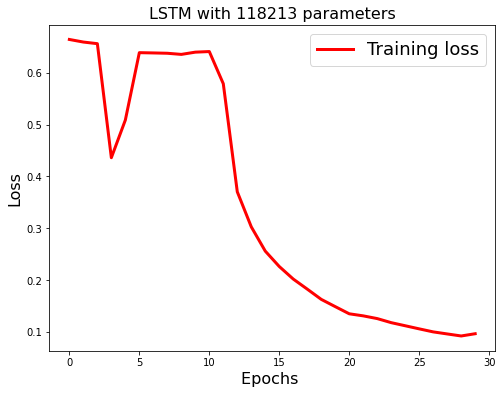

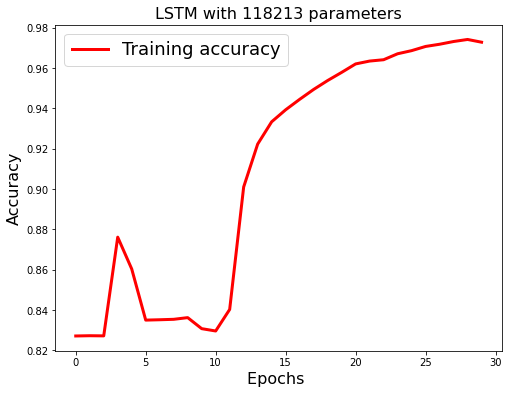

In [ ]:
plt.figure(figsize=[8,6])
plt.plot(loss,'r',linewidth=3.0)
plt.legend(['Training loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)  
plt.title("LSTM with {0} parameters".format(number_parameters),fontsize=16)

plt.figure(figsize=[8,6]) 
plt.plot(accuracy,'r',linewidth=3.0) 
plt.legend(['Training accuracy'],fontsize=18) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16)
plt.title("LSTM with {0} parameters".format(number_parameters),fontsize=16) 

# Predictions and confusion matrix

In [ ]:
#pred_test = model.predict(X_test[:,:,0])
pred_test = model.predict(X_test)
pred_test = np.argmax(pred_test, axis=-1)

f1 = f1_score(Y_test, pred_test, average="macro")

print("Test f1 score : %s "% f1)

acc = accuracy_score(Y_test, pred_test)

print("Test accuracy score : %s "% acc)

Test f1 score : 0.7862063168318926 
Test accuracy score : 0.9418509044399781 


Normalized confusion matrix
[[9.88850867e-01 1.60061817e-03 6.51286014e-03 1.49023071e-03
  1.54542444e-03]
 [4.96402878e-01 4.65827338e-01 2.87769784e-02 0.00000000e+00
  8.99280576e-03]
 [3.23895028e-01 1.38121547e-03 6.54696133e-01 1.17403315e-02
  8.28729282e-03]
 [2.59259259e-01 0.00000000e+00 5.55555556e-02 6.79012346e-01
  6.17283951e-03]
 [1.31218905e-01 6.21890547e-04 6.21890547e-03 0.00000000e+00
  8.61940299e-01]]


<Figure size 432x288 with 0 Axes>

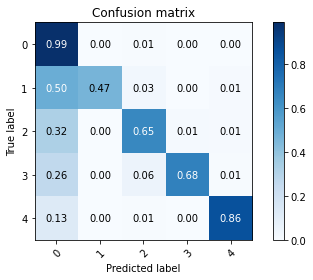

In [ ]:
# Code from scikit-learn

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]), 
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")
  

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

cnf_matrix = confusion_matrix(Y_test, pred_test)
class_names = [str(i) for i in range(5)]

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True)
plt.show()